In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date, timedelta
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

today = date.today()
d1 = today.strftime("%Y-%m-%d")
end_date = d1

d2 = date.today() - timedelta(days=365)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

data = yf.download('MSFT', start=start_date, end=end_date,progress=False)
data["Date"] = data.index
data = data[["Date", "Open", "High", "Low","Close", "Adj Close", "Volume"]]
data.reset_index(drop=True, inplace=True)
print(data.head())

        Date        Open        High         Low       Close   Adj Close  \
0 2023-05-30  335.230011  335.739990  330.519989  331.209991  328.639191   
1 2023-05-31  332.290009  335.940002  327.329987  328.390015  325.841064   
2 2023-06-01  325.929993  333.529999  324.720001  332.579987  329.998535   
3 2023-06-02  334.250000  337.500000  332.549988  335.399994  332.796631   
4 2023-06-05  335.220001  338.559998  334.660004  335.940002  333.332458   

     Volume  
0  29503100  
1  45950600  
2  26773900  
3  25864000  
4  21307100  


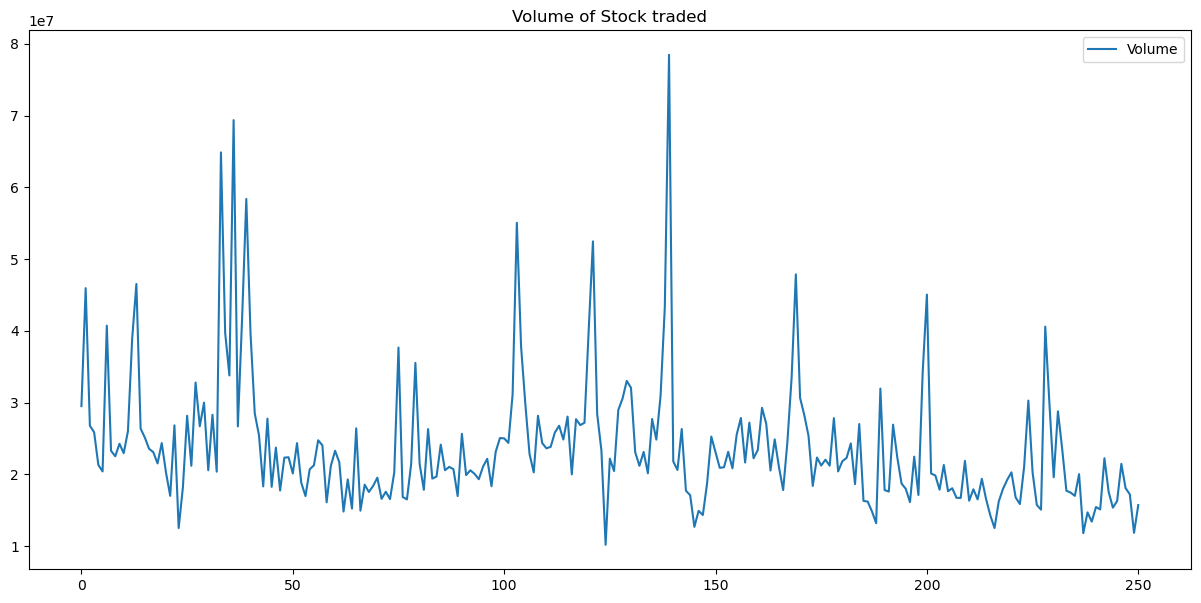

In [2]:
data['Volume'].plot(figsize = (15,7))
plt.title('Volume of Stock traded')
plt.legend()

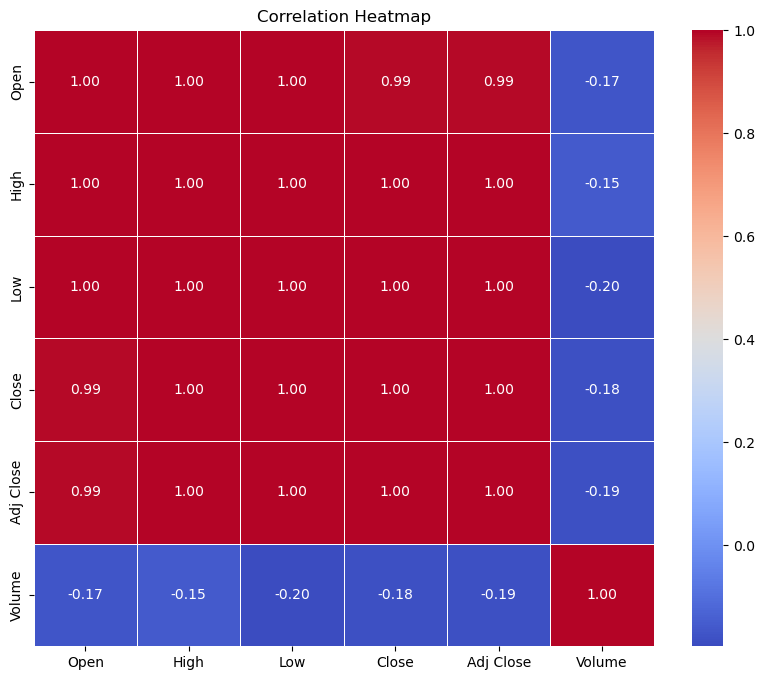

In [3]:
correlation_matrix = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title(f'Correlation Heatmap')
plt.show()

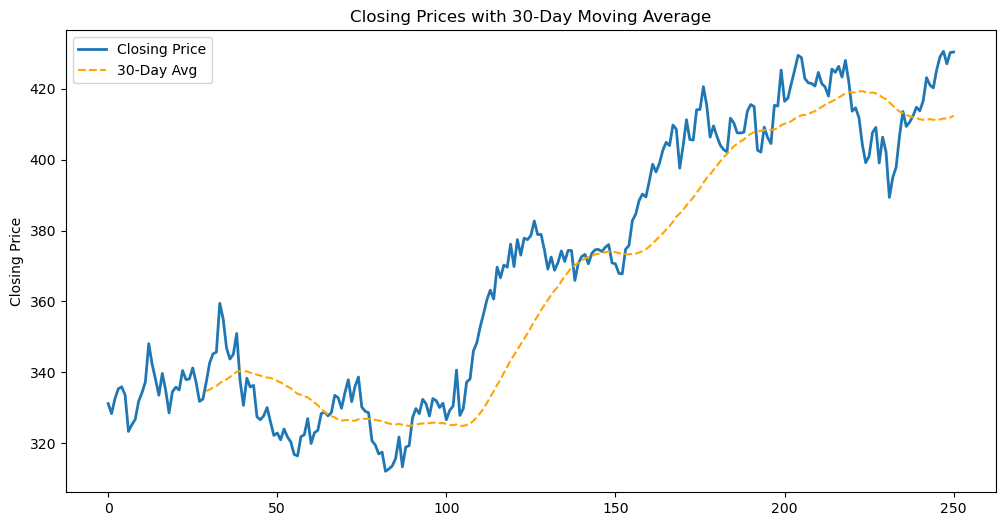

In [4]:
plt.figure(figsize=(12, 6))
data['Close'].plot(label= 'Closing Price', linewidth=2)
data['Close'].rolling(window=30).mean().plot(label='30-Day Avg', linestyle='--', color='orange')
plt.title('Closing Prices with 30-Day Moving Average')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [5]:
data.describe() 

,Open,High,Low,Close,Adj Close,Volume
count,251.000000,251.000000,251.000000,251.000000,251.000000,2.510000e+02
mean,369.109761,372.139603,365.856613,369.090717,367.524832,2.380195e+07
std,37.467455,37.332583,37.332674,37.501473,38.111260,9.171764e+06
min,310.989990,314.299988,309.450012,312.140015,310.372955,1.017660e+07
25%,333.395004,336.125000,329.379990,332.445007,330.089340,1.806710e+07
50%,369.299988,373.100006,367.000000,370.600006,369.249908,2.152060e+07
75%,407.529999,409.910004,403.705002,406.440002,405.708221,2.654455e+07
max,432.970001,433.600006,427.160004,430.519989,430.519989,7.847820e+07


In [6]:
close_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = scaler.fit_transform(close_prices)

In [7]:
def create_lstm_data(data, time_steps=1):
 x, y = [], []
 for i in range(len(data) - time_steps):
     x.append(data[i:(i + time_steps), 0])
     y.append(data[i + time_steps, 0])
     return np.array(x), np.array(y)

In [8]:
time_steps = 10
x,y = create_lstm_data(close_prices_scaled, time_steps)
x = np.reshape(x, (x.shape[0], x.shape[1], 1))

In [9]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
model.fit(x, y, epochs=50, batch_size=32)

Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 0.0346
Epoch 2/50
1/1 [==============================] - 0s 12ms/step - loss: 0.0281
Epoch 3/50
1/1 [==============================] - 0s 12ms/step - loss: 0.0200
Epoch 4/50
1/1 [==============================] - 0s 14ms/step - loss: 0.0126
Epoch 5/50
1/1 [==============================] - 0s 13ms/step - loss: 0.0078
Epoch 6/50
1/1 [==============================] - 0s 13ms/step - loss: 0.0031
Epoch 7/50
1/1 [==============================] - 0s 11ms/step - loss: 5.2609e-05
Epoch 8/50
1/1 [==============================] - 0s 9ms/step - loss: 0.0011
Epoch 9/50
1/1 [==============================] - 0s 11ms/step - loss: 0.0051
Epoch 10/50
1/1 [==============================] - 0s 12ms/step - loss: 0.0052
Epoch 11/50
1/1 [==============================] - 0s 10ms/step - loss: 0.0037
Epoch 12/50
1/1 [==============================] - 0s 10ms/step - loss: 0.0027
Epoch 13/50
1/1 [==============================] - 0s 9ms/st

In [11]:
future_dates = pd.date_range(start=end_date, periods=30)
predicted_prices = []
last_prices = close_prices[-time_steps:]
last_prices_scaled = scaler.transform(last_prices.reshape(-1, 1))
for _ in range(30):
    x_pred = np.array([last_prices_scaled[-time_steps:, 0]])
    x_pred = np.reshape(x_pred, (x_pred.shape[0], x_pred.shape[1], 1))
    predicted_price_scaled = model.predict(x_pred)
    predicted_price = scaler.inverse_transform(predicted_price_scaled)
    predicted_prices.append(predicted_price[0, 0])
    last_prices_scaled = np.append(last_prices_scaled, predicted_price_scaled)[-time_steps:]
    last_prices_scaled = last_prices_scaled.reshape(-1, 1)

1/1 [==============================] - 0s 17ms/step


In [12]:
future_data = pd.DataFrame({'Date': future_dates, 'Predicted Price': predicted_prices})
print(future_data)

         Date  Predicted Price
0  2024-05-29       355.127869
1  2024-05-30       355.255341
2  2024-05-31       354.843781
3  2024-06-01       354.107391
4  2024-06-02       353.006226
5  2024-06-03       351.392426
6  2024-06-04       349.362213
7  2024-06-05       347.044128
8  2024-06-06       344.655701
9  2024-06-07       342.039795
10 2024-06-08       339.344818
11 2024-06-09       339.066467
12 2024-06-10       338.714600
13 2024-06-11       338.314178
14 2024-06-12       337.885956
15 2024-06-13       337.452911
16 2024-06-14       337.042023
17 2024-06-15       336.675354
18 2024-06-16       336.368469
19 2024-06-17       336.127838
20 2024-06-18       335.963135
21 2024-06-19       335.877533
22 2024-06-20       335.791595
23 2024-06-21       335.709534
24 2024-06-22       335.634613
25 2024-06-23       335.569122
26 2024-06-24       335.514313
27 2024-06-25       335.470215
28 2024-06-26       335.435852
29 2024-06-27       335.409729
